In [16]:
import pandas as pd
import numpy as np
from pathlib import Path
import warnings

# Silence warnings (keeps notebook clean)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# === Global runtime context (shared between tools) ===
STATE = {
    "df": None,       # the active DataFrame
    "name": None,     # dataset name
    "schema": None,   # LLM-provided schema
}


In [15]:
# === Core MCP-ready data tools (no heuristics, no auto checks) ===
# The LLM supplies decisions (schema, columns, thresholds). These functions just execute.

import pandas as pd
import numpy as np
import plotly.express as px
from pathlib import Path
from typing import Dict, List, Tuple, Any, Optional

STATE: Dict[str, Any] = {"df": None, "name": None, "schema": None}

# ---- Data I/O ----
def load_data(path: str) -> Dict[str, Any]:
    df = pd.read_csv(path)
    STATE["df"] = df
    STATE["name"] = Path(path).name
    return {"ok": True, "dataset": STATE["name"], "rows": len(df), "cols": df.shape[1]}

def set_schema(schema: Dict[str, List[str]]) -> Dict[str, Any]:
    """
    LLM-provided schema. Example keys: numeric, categorical, datetime, temporal, unique_id, unclassified.
    This function does not validate; it stores whatever is provided.
    """
    STATE["schema"] = schema
    return {"ok": True, "keys": list(schema.keys())}

def get_schema() -> Dict[str, Any]:
    return {"ok": STATE["schema"] is not None, "schema": STATE["schema"]}

# ---- Summaries ----
def summary(numeric_only: bool = True) -> Dict[str, Any]:
    df = STATE["df"]; assert df is not None
    if numeric_only:
        desc = df.describe().T
    else:
        desc = df.describe(include="all").T
    return {"ok": True, "rows": len(df), "cols": df.shape[1], "describe": desc}

def head(n: int = 5):
    df = STATE["df"]; assert df is not None
    return df.head(n)

# ---- Categorical (LLM decides which columns) ----
def top_categories(columns: List[str], top_n: int = 10) -> Dict[str, Any]:
    df = STATE["df"]; assert df is not None
    out = {}
    for c in columns:
        out[c] = df[c].astype(str).value_counts(dropna=True).head(top_n)
        # Optional plot per column (LLM decides when to call)
        bar_df = out[c].reset_index(); bar_df.columns = [c, "count"]
        fig = px.bar(bar_df, x=c, y="count", title=f"Top {top_n}: {c}")
        fig.update_layout(xaxis_tickangle=-30)
        fig.show()
    return {"ok": True, "columns": columns}

# ---- Correlations (LLM supplies the exact columns or pairs) ----
def correlations(columns: Optional[List[str]] = None, method: str = "pearson") -> Dict[str, Any]:
    df = STATE["df"]; assert df is not None
    if columns is None:
        corr = df.corr(numeric_only=True, method=method)
    else:
        corr = df[columns].corr(method=method)
    return {"ok": True, "method": method, "corr": corr}

def scatter_pairs(pairs: List[Tuple[str, str]]) -> Dict[str, Any]:
    df = STATE["df"]; assert df is not None
    for x, y in pairs:
        fig = px.scatter(df, x=x, y=y, trendline="ols", title=f"{x} vs {y}")
        fig.show()
    return {"ok": True, "pairs_plotted": len(pairs)}

# ---- Outliers (LLM chooses columns & threshold) ----
def outliers(columns: List[str], z: float = 3.0) -> Dict[str, Any]:
    df = STATE["df"]; assert df is not None
    sub = df[columns]
    zscores = (sub - sub.mean()) / (sub.std(ddof=0) + 1e-9)
    mask = (zscores.abs() > z).any(axis=1)
    idx = df.index[mask].tolist()
    return {"ok": True, "count": len(idx), "indices": idx}

# ---- Missing values (LLM supplies threshold) ----
def missing(threshold: float = 0.20) -> Dict[str, Any]:
    df = STATE["df"]; assert df is not None
    miss = df.isna().mean()
    flagged = miss[miss > threshold].sort_values(ascending=False)
    return {"ok": True, "threshold": threshold, "missing": flagged}

# ---- Distributions / XY plots (LLM specifies exactly what to plot) ----
def plot_hist(column: str, nbins: int = 30) -> Dict[str, Any]:
    df = STATE["df"]; assert df is not None
    fig = px.histogram(df, x=column, nbins=nbins, title=f"Distribution: {column}")
    fig.show()
    return {"ok": True}

def plot_xy(x: str, y: str) -> Dict[str, Any]:
    df = STATE["df"]; assert df is not None
    fig = px.scatter(df, x=x, y=y, trendline="ols", title=f"{x} vs {y}")
    fig.show()
    return {"ok": True}

# ---- Time trends (LLM chooses the column & aggregation) ----
def time_trend(column: str, freq: str = "M") -> Dict[str, Any]:
    """
    Expect a datetime column or a year-like integer column (LLM decides which).
    If it's integer-like years, we aggregate by the integer values directly.
    If it's datetime, we resample/count by freq.
    """
    df = STATE["df"]; assert df is not None
    s = df[column]

    # If datetime-like, group by resampled period count
    if pd.api.types.is_datetime64_any_dtype(s):
        grp = s.dropna().dt.to_period(freq).value_counts().sort_index()
        x = grp.index.astype(str); y = grp.values
        title = f"Count by {freq}: {column}"
        fig = px.line(x=x, y=y, labels={"x": column, "y": "count"}, title=title)
        fig.show()
        return {"ok": True, "type": "datetime"}

    # Else: treat as year-like numbers (LLM ensured this)
    ser = pd.to_numeric(s, errors="coerce").dropna().astype(int)
    grp = ser.value_counts().sort_index()
    fig = px.line(x=grp.index, y=grp.values, labels={"x": column, "y": "count"},
                  title=f"Count by Year: {column}")
    fig.show()
    return {"ok": True, "type": "year-int"}


In [17]:
# === Minimal tool registry & invoker (MCP-ready shim) ===
import json
from typing import Callable

# 1) Register every callable tool you want exposed
TOOLS: dict[str, Callable] = {
    "load_data": load_data,
    "set_schema": set_schema,
    "get_schema": get_schema,
    "summary": summary,
    "head": head,
    "top_categories": top_categories,
    "correlations": correlations,
    "scatter_pairs": scatter_pairs,
    "outliers": outliers,
    "missing": missing,
    "plot_hist": plot_hist,
    "plot_xy": plot_xy,
    "time_trend": time_trend,
}

# 2) Simple invoker that matches MCP-style name + args dict
def invoke_tool(name: str, args: dict | None = None):
    if name not in TOOLS:
        return {"ok": False, "error": f"unknown_tool:{name}"}
    fn = TOOLS[name]
    args = args or {}
    try:
        result = fn(**args)
        # pandas objects (DataFrames/Series) aren’t JSON—stringify minimal bits
        def _serialize(x):
            if hasattr(x, "to_dict"):
                return x.to_dict()
            if hasattr(x, "to_json"):
                return json.loads(x.to_json())
            return x
        if isinstance(result, dict):
            return {k: _serialize(v) for k, v in result.items()}
        return _serialize(result)
    except AssertionError as e:
        return {"ok": False, "error": f"assert:{e}"}
    except Exception as e:
        return {"ok": False, "error": f"exception:{type(e).__name__}:{e}"}

{'ok': True, 'dataset': 'netflix_titles_CLEANED.csv', 'rows': 8807, 'cols': 12}
{'ok': True, 'keys': ['numeric', 'categorical', 'datetime', 'temporal', 'unique_id', 'unclassified']}
{'ok': True, 'schema': {'numeric': ['release_year'], 'categorical': ['type', 'country'], 'datetime': [], 'temporal': ['release_year'], 'unique_id': ['show_id'], 'unclassified': []}}
{'ok': True, 'rows': 8807, 'cols': 12}


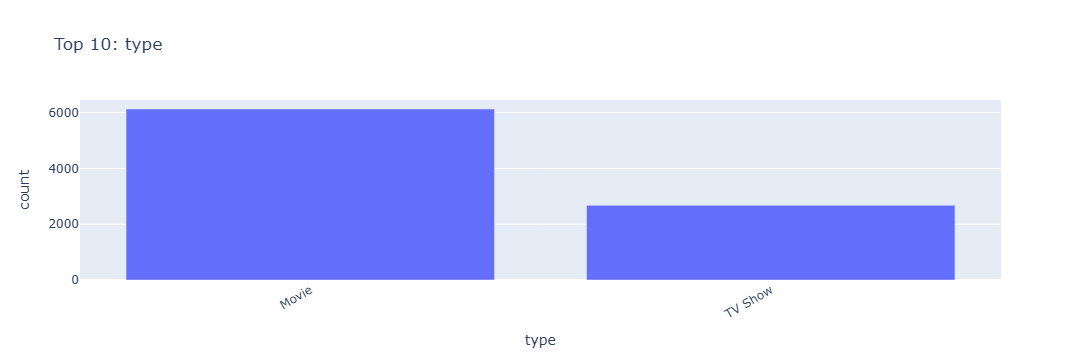

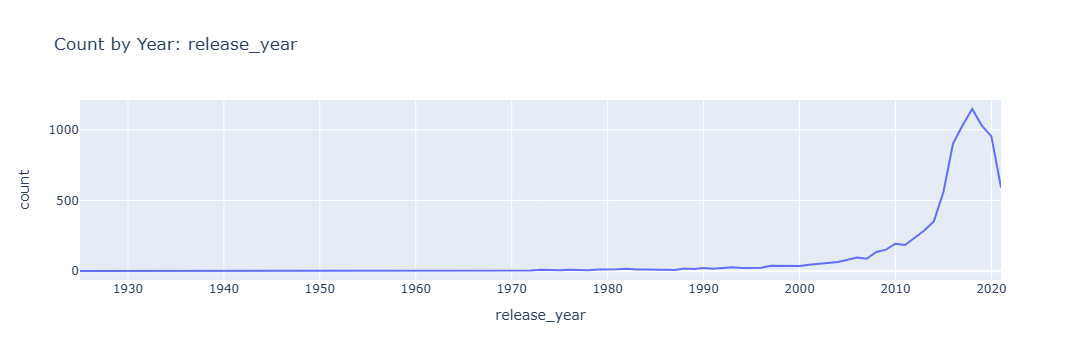

{'ok': True, 'type': 'year-int'}

In [19]:
# Load a CSV
print(invoke_tool("load_data", {"path": "netflix_titles_CLEANED.csv"}))

# (Optional) let “LLM” set a schema it decided
schema = {
    "numeric": ["release_year"],
    "categorical": ["type", "country"],
    "datetime": [],
    "temporal": ["release_year"],
    "unique_id": ["show_id"],
    "unclassified": [],
}
print(invoke_tool("set_schema", {"schema": schema}))
print(invoke_tool("get_schema"))

# Ask for a summary
res = invoke_tool("summary", {"numeric_only": True})
print({k: v for k, v in res.items() if k != "describe"})  # avoid spamming output

# Top categories (LLM chooses which columns)
invoke_tool("top_categories", {"columns": ["type", "country"], "top_n": 10})

# Correlations (LLM decides columns)
invoke_tool("correlations", {"columns": ["release_year"]})

# Time trend (LLM picks the temporal column)
invoke_tool("time_trend", {"column": "release_year", "freq": "Y"})


In [20]:
!pip install mcp pandas numpy plotly

   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 2.0/2.0 MB 29.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/3.5 MB ? eta -:--:--
   ---------------------------------------- 3.5/3.5 MB 38.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------  9.4/9.5 MB 52.0 MB/s eta 0:00:01
   ---------------------------------------- 9.5/9.5 MB 35.9 MB/s eta 0:00:00

   ----------------------------------------  0/16 [pywin32]
   ----------------------------------------  0/16 [pywin32]
   ----------------------------------------  0/16 [pywin32]
   ----------------------------------------  0/16 [pywin32]
   ----------------------------------------  0/16 [pywin32]
   ----------------------------------------  0/16 [pywin32]
   ----------------------------------------  0/16 [pywin32]
   ----------------------------------------  0/16 [pywin32]
   -


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
!pip install mcp


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
pip install "mcp[cli]"


   -------- ------------------------------- 1/5 [mdurl]
   ---------------- ----------------------- 2/5 [markdown-it-py]
   ---------------- ----------------------- 2/5 [markdown-it-py]
   ---------------- ----------------------- 2/5 [markdown-it-py]
   ---------------- ----------------------- 2/5 [markdown-it-py]
   ---------------- ----------------------- 2/5 [markdown-it-py]
   ---------------- ----------------------- 2/5 [markdown-it-py]
   ---------------- ----------------------- 2/5 [markdown-it-py]
   ---------------- ----------------------- 2/5 [markdown-it-py]
   ---------------- ----------------------- 2/5 [markdown-it-py]
   ------------------------ --------------- 3/5 [rich]
   ------------------------ --------------- 3/5 [rich]
   ------------------------ --------------- 3/5 [rich]
   ------------------------ --------------- 3/5 [rich]
   ------------------------ --------------- 3/5 [rich]
   ------------------------ --------------- 3/5 [rich]
   ------------------------ 


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
async def my_function():
    print("Start")
    await asyncio.sleep(2)
    print("End")


In [26]:
import asyncio
asyncio.run(my_function())

RuntimeError: asyncio.run() cannot be called from a running event loop

In [25]:
my_function()

<coroutine object my_function at 0x0000021CFA497B80>